# Agentes en LangGraph con Gemini


## Caso 3 Paralelizado

<img src="https://langchain-ai.github.io/langgraph/tutorials/workflows/img/parallelization.png" alt="gate" width="600"/>


Con la paralelización, los LLM trabajan simultáneamente en una tarea:

En ocasiones, los LLM pueden trabajar simultáneamente en una tarea y sus resultados se agregan programáticamente. Este flujo de trabajo, la paralelización, se manifiesta en dos variantes clave: Seccionamiento: Dividir una tarea en subtareas independientes que se ejecutan en paralelo. Votación: Ejecutar la misma tarea varias veces para obtener resultados diversos.

Cuándo usar este flujo de trabajo: La paralelización es eficaz cuando las subtareas divididas se pueden paralelizar para mayor velocidad, o cuando se requieren múltiples perspectivas o intentos para obtener resultados más fiables. Para tareas complejas con múltiples consideraciones, los LLM suelen tener un mejor rendimiento cuando cada consideración se gestiona mediante una llamada LLM independiente, lo que permite centrarse en cada aspecto específico.


In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

In [2]:
import os
import getpass
from langchain_google_genai import ChatGoogleGenerativeAI

# Declaración y llamado de la key del modelo LLM
# use esta función para definir la key del modelo LLM si tuvo problemas con el archivo .env.json o create_env.py
def _set_env(var: str):
   if not os.environ.get(var):
       os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

### ¿Qué es `State` y qué función cumple en el grafo?

El `State` es una estructura (aquí un `TypedDict`) que representa el estado compartido entre los diferentes nodos del grafo. 
Contiene todas las variables que se van generando, modificando o utilizando a lo largo del flujo, como por ejemplo: el tema (`topic`), el chiste (`joke`), la historia (`story`), el poema (`poem`) y la salida combinada (`combined_output`). 
Cada nodo del grafo puede leer y actualizar partes de este estado, permitiendo que la información fluya y se transforme paso a paso durante el procesamiento paralelo.

In [3]:
# Estado del grafo
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


### Nodos

Hacemos la construcción de los mismos grafos del ejemplo anterior

In [4]:
# Definición de nodos

def call_llm_1(state: State):
    """
    Genera un chiste sobre el tema proporcionado.

    Parámetros:
        state (State): Diccionario de estado que debe contener la clave 'topic' (str) con el tema sobre el cual se generará el chiste.

    Retorna:
        dict: Diccionario con la clave 'joke' (str) que contiene el chiste generado.

    Descripción:
        Esta función utiliza el modelo LLM para crear un chiste en español sobre el tema especificado en 'state["topic"]'.
    """
    msg = llm.invoke(f"Escribe un chiste sobre {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """
    Genera una historia sobre el tema proporcionado.

    Parámetros:
        state (State): Diccionario de estado que debe contener la clave 'topic' (str) con el tema sobre el cual se generará la historia.

    Retorna:
        dict: Diccionario con la clave 'story' (str) que contiene la historia generada.

    Descripción:
        Esta función utiliza el modelo LLM para crear una historia en español sobre el tema especificado en 'state["topic"]'.
    """
    msg = llm.invoke(f"Escribe una historia sobre {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """
    Genera un poema sobre el tema proporcionado.

    Parámetros:
        state (State): Diccionario de estado que debe contener la clave 'topic' (str) con el tema sobre el cual se generará el poema.

    Retorna:
        dict: Diccionario con la clave 'poem' (str) que contiene el poema generado.

    Descripción:
        Esta función utiliza el modelo LLM para crear un poema en español sobre el tema especificado en 'state["topic"]'.
    """
    msg = llm.invoke(f"Escribe un poema sobre {state['topic']}")
    return {"poem": msg.content}

def aggregator(state: State):
    """
    Combina el chiste, la historia y el poema en una sola salida.

    Parámetros:
        state (State): Diccionario de estado que debe contener las claves 'topic' (str), 'joke' (str), 'story' (str) y 'poem' (str).

    Retorna:
        dict: Diccionario con la clave 'combined_output' (str) que contiene la combinación de la historia, el chiste y el poema.

    Descripción:
        Esta función toma los resultados generados (chiste, historia y poema) sobre el tema especificado en 'state["topic"]'
        y los une en un solo texto en español, presentando cada uno con su respectivo encabezado.
    """
    combinado = f"¡Aquí tienes una historia, un chiste y un poema sobre {state['topic']}!\n\n"
    combinado += f"HISTORIA:\n{state['story']}\n\n"
    combinado += f"CHISTE:\n{state['joke']}\n\n"
    combinado += f"POEMA:\n{state['poem']}"
    return {"combined_output": combinado}


### Flujo

Contruimos el flujo igual al caso anterior


In [5]:
# Construir flujo de trabajo
parallel_builder = StateGraph(State)

### Definición de nodos

Al igual que caso anterior agregamos los nodos al flujo

In [6]:
# Agregamos los nodos
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)


### Definición de aristas


En la agregación de aristas paralelizadas, se definen las conexiones (edges) entre los nodos del grafo de manera que, a partir del nodo inicial (START), se disparan simultáneamente varias ramas independientes hacia diferentes nodos de procesamiento (en este caso, los nodos que generan la historia, el chiste y el poema). 

Cada una de estas ramas ejecuta su tarea en paralelo, permitiendo que los tres procesos ocurran al mismo tiempo y no de forma secuencial. 

Una vez que cada rama termina su tarea, todas convergen en un nodo agregador ("aggregator"), que se encarga de reunir los resultados parciales y combinarlos en una única salida final. 

Finalmente, el flujo continúa hacia el nodo final (END), completando así el procesamiento paralelo y la integración de los resultados.


In [7]:
# Agregamos las aristas
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()


### Visualización del grafo
El siguiente código utiliza la función `display` para mostrar visualmente el grafo del workflow que hemos construido. 
Específicamente, `chain.get_graph().draw_mermaid_png()` genera una imagen del grafo utilizando el formato Mermaid, 
permitiendo ver de manera gráfica cómo están conectados los nodos y las aristas del flujo de trabajo.
Esto facilita la comprensión de la estructura y la lógica del workflow, mostrando de forma clara el recorrido que sigue la información entre los diferentes pasos.


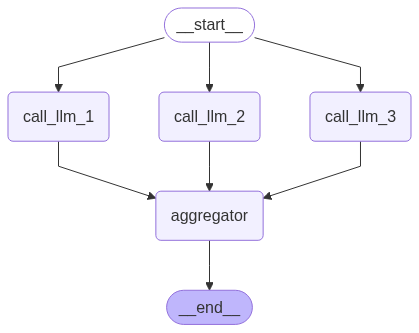

In [8]:
# Visualizamos el workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

### LLamado
Ahora que hemos definido y compilado el grafo siguiendo los pasos anteriores, ya podemos invocarlo para ejecutar el flujo de trabajo y obtener resultados.


In [9]:
# Invocar
salida = state = parallel_workflow.invoke({"topic": "cats"})

print(salida["combined_output"])


¡Aquí tienes una historia, un chiste y un poema sobre cats!

HISTORIA:
En un rincón tranquilo del mundo, donde los árboles susurraban secretos al viento y el sol dibujaba manchas doradas sobre la tierra, existía un reino secreto habitado por gatos. No eran gatos ordinarios; estos felinos poseían una gracia y sabiduría inigualables, sus ojos brillaban con una antigua magia. Su líder, una magnífica gata atigrada llamada Celeste, poseía una profunda comprensión de las estrellas y el susurro del universo.

Una noche, mientras las estrellas centelleaban como diamantes esparcidos sobre un paño de terciopelo, Celeste recibió una profecía. Una gran oscuridad amenazaba con envolver su reino, trayendo consigo una fría noche eterna. La única esperanza residía en una legendaria Flor de la Luna, que se decía que florecía solo en la cima de la montaña más alta, bañada por la luz de la luna llena.

Con el corazón apesadumbrado pero resuelto, Celeste reunió a sus gatos más valientes. Entre ellos se en